In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.integrate import quad 
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import display
import ipywidgets as widgets
import os
from ipywidgets import interact, IntSlider, Button, VBox, Output

In [2]:
# Leer el archivo CSV con separador y decimal correctos
df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)

wavelength = df['Wavelength'].values

flux = df['Normalised_Flux'].values


C:\Users\Jessi Dani\AppData\Local\Temp\ipykernel_12516\1429585468.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('Alfa_Boo_pepsi.csv', delim_whitespace=True)


In [3]:
df_hierro = pd.read_excel('lista de lineas Arcturus.xlsx', header=7, usecols=['l aire', 'l aire m'])

fe_1_lineas = df_hierro['l aire']
fe_1_lineas = fe_1_lineas.dropna().values

fe_1_lineas_mezclas = df_hierro['l aire m']
fe_1_lineas_mezclas = fe_1_lineas_mezclas.dropna().values



In [4]:
fe_1_lineas

array([3940.8776, 4029.6293, 4059.7135, 4073.7623, 4080.2092, 4085.0041,
       4087.0939, 4089.2169, 4109.0561, 4120.2065, 4139.9273, 4154.4987,
       4154.8055, 4158.7924, 4175.6361, 4184.8918, 4207.1271, 4208.604 ,
       4222.2131, 4233.6028, 4264.2034, 4266.9645, 4285.442 , 4343.6975,
       4346.5526, 4348.9366, 4432.5678, 4436.9206, 4442.339 , 4445.4715,
       4446.8321, 4447.1304, 4447.7173, 4454.381 , 4456.3257, 4461.6528,
       4481.6093, 4484.2198, 4485.6756, 4489.7391, 4490.084 , 4494.5632,
       4502.5909, 4517.5245, 4547.8474, 4556.1259, 4598.1171, 4602.001 ,
       4602.941 , 4618.7577, 4619.288 , 4625.0453, 4630.1203, 4635.8462,
       4637.5034, 4643.4634, 4678.8458, 4683.5597, 4704.9481, 4721.0006,
       4735.8439, 4736.7734, 4741.5297, 4786.807 , 4787.8269, 4788.7569,
       4798.2649, 4799.4061, 4832.7276, 4839.5445, 4843.1438, 4845.6482,
       4859.7414, 4871.3182, 4875.8776, 4882.1434, 4885.4306, 4886.3318,
       4892.8589, 4907.7318, 4909.3835, 4910.0169, 

In [5]:
z_max = 2e-5

resolucion = np.mean(np.diff(wavelength))
separacion_minima = round(np.min(np.diff(fe_1_lineas)),4)
distancia = int(np.ceil(separacion_minima/resolucion))

def encontrar_lambda_teorica(centro):
    diferencias = np.abs(fe_1_lineas - centro)
    tolerancias = z_max * fe_1_lineas + resolucion
    idx = np.argmin(diferencias)  
    if diferencias[idx] <= tolerancias[idx]:
        return fe_1_lineas[idx]
    else:
        return None

In [6]:
inv_flux = 1 - flux
picos, _ = find_peaks(
    inv_flux,
    prominence=0.03,       
    distance=distancia,          
                   
)

picos_filtrados = []
for pico in picos:
    lambda_pico = wavelength[pico]
    lambda_teorica = encontrar_lambda_teorica(lambda_pico)
    if lambda_teorica is not None:
        picos_filtrados.append(pico)


ventana = 5
centros_interpolados = []
polinomios = []
area_polinomio_interpolador = []
profundidad_real = []

for pico in picos:
    if pico - ventana < 0 or pico + ventana >= len(wavelength):
        continue
    
    x = wavelength[pico - ventana:pico + ventana + 1]
    y = flux[pico - ventana:pico + ventana + 1]
    
   
    x_centro = x.mean()
    x_reubicado = x - x_centro

    
    coef = np.polyfit(x_reubicado, y, deg=4)
    p = Polynomial(coef[::-1])

 
    def polinomio_recentrado(lmbda):
        return p(lmbda - x_centro)

   
    area_polinomio, _ = quad(polinomio_recentrado, x[0], x[-1])
    area_polinomio_interpolador.append(area_polinomio)

    """
    profundidad_equivalente = (x[-1] - x[0]) - area_polinomio
    profundidad_real.append(profundidad_equivalente)

    """


    dp = p.deriv()
    raices = dp.roots()
    raices_reales = raices[np.isreal(raices)].real
    raices_en_intervalo = [r for r in raices_reales if x_reubicado.min() <= r <= x_reubicado.max()]
    
    if raices_en_intervalo:
        minimo_reubicado = raices_en_intervalo[np.argmin(p(raices_en_intervalo))]
        minimo = minimo_reubicado + x_centro   
        centros_interpolados.append(minimo)
        polinomios.append((p, x_centro))   


print(f"Total de picos detectados: {len(picos)}")

Total de picos detectados: 7989


In [7]:
print(centros_interpolados)

[np.float64(3823.327639417272), np.float64(3823.521879518761), np.float64(3823.686343022256), np.float64(3823.880000407164), np.float64(3824.0925819622257), np.float64(3824.3250122344257), np.float64(3824.509068090746), np.float64(3824.9348242365995), np.float64(3825.097461679778), np.float64(3825.2568963188223), np.float64(3825.4331714824034), np.float64(3825.668808630113), np.float64(3825.7977624847754), np.float64(3825.9812565722355), np.float64(3826.21903537417), np.float64(3826.4025312643153), np.float64(3826.6643836103885), np.float64(3826.849332681513), np.float64(3826.9739668310453), np.float64(3827.3125371498013), np.float64(3827.4399651239873), np.float64(3827.6326512814776), np.float64(3827.8253887147275), np.float64(3828.18395296298), np.float64(3828.3761091504975), np.float64(3828.558420118753), np.float64(3828.847104983868), np.float64(3829.013780770964), np.float64(3829.212129431365), np.float64(3829.3993782680686), np.float64(3829.5533731649903), np.float64(3829.7083077

In [8]:
os.makedirs("graficas_lineas", exist_ok=True)

calculo_z = []
calculo_v = []
calculo_lambda = []
calculo_area = []
coeficiente_0 = []
coeficiente_1 = []
coeficiente_2 = []
coeficiente_3 = []
coeficiente_4 = []
flujo_centro_lista = []
f1_lista = []
f2_lista = []
f3_lista = []
profundidad_grafica = []

centro_filtrado = []
profundidad_filtrada_l = []

c_km_s = 299792

print("Total de líneas detectadas:", len(centros_interpolados))

for i, (centro, (p, x_centro)) in enumerate(zip(centros_interpolados, polinomios)):

    lambda_teorica = encontrar_lambda_teorica(centro)
    if lambda_teorica is None:
        continue

    z = (centro - lambda_teorica) / lambda_teorica
    v = z * c_km_s

    if not (-1.0 <= v <= 1.0):
        print(f"v = {v:.3f} km/s fuera de rango para λ_obs = {centro:.3f}, λ_teo = {lambda_teorica:.3f}")
        continue


    centro_filtrado.append(centro)
    calculo_z.append(z)
    calculo_v.append(v)
    calculo_lambda.append(lambda_teorica)

    """
    profundidad_filtrada_l.append(profundidad_real[i])
    """

    indice_cercano = np.argmin(np.abs(wavelength - centro))
    if indice_cercano - ventana < 0 or indice_cercano + ventana >= len(wavelength):
        continue

    x = wavelength[indice_cercano - ventana: indice_cercano + ventana + 1]
    y = flux[indice_cercano - ventana: indice_cercano + ventana + 1]

    delta_lambda = np.diff(x)  
    altura_promedio = 1 - y[1:]
    area = np.sum(altura_promedio * delta_lambda) 

    calculo_area.append(area)



    x_fina = np.linspace(x[0], x[-1], 200)
    y_fina = p(x_fina - x_centro)

    flujo = p(centro-x_centro)
    flujo_centro_lista.append(flujo) 
    coef = p.coef

    ecuacion = r"$P(X) = {:.3e} + {:.3e}x + {:.3e}x^2 + {:.3e}x^3 + {:.3e}x^4$".format(
        coef[0], coef[1], coef[2], coef[3], coef[4])

    coeficiente_0.append(coef[0])
    coeficiente_1.append(coef[1])
    coeficiente_2.append(coef[2])
    coeficiente_3.append(coef[3])
    coeficiente_4.append(coef[4])

    flujo_f_1 = p.deriv(1)(centro-x_centro)
    f1_lista.append(flujo_f_1)

    flujo_f_2 = p.deriv(2)(centro-x_centro)
    f2_lista.append(flujo_f_2)
    
    flujo_f_3 = p.deriv(3)(centro-x_centro)
    f3_lista.append(flujo_f_3)

    profundidad_flujo = 1 - flujo
    profundidad_grafica.append(profundidad_flujo)

    

    leyenda = (f"Área = {area:.5f} Å\n"
               f"Coeficientes: \n {ecuacion} \n"
               f"Profundidad: = {profundidad_flujo:.4f} \n"
               f"Asimetría = {flujo_f_3:.4f}")
    
    plt.figure(figsize=(14, 7))
    plt.plot(x, y, label="Espectro")
    plt.plot(x_fina, y_fina, 'yellow', label="Interpolación polinómica")
    plt.fill_between(x, y, 1, color='pink', alpha=0.4, label=leyenda)
    plt.axvline(centro, color='purple', linestyle='--', lw=1, label="Centro interpolado")
    if lambda_teorica:
        plt.axvline(lambda_teorica, color='red', linestyle=':', lw=1, label="Línea teórica")
    plt.title(f"λ_obs (Å) = {centro:.4f}; z = {z:.3e}; v = {v:.3g} [km/s]")
    plt.xlabel("Longitud de onda [Å]")
    plt.ylabel("Flujo normalizado")
    plt.legend()
    plt.tight_layout()

    nombre_archivo = f"graficas_lineas/linea_{centro:.4f}.png"
    plt.savefig(nombre_archivo)
    plt.close()

#Aunque no se utilizan explicitamente f1 y f2, el primero sirvió para verificar que todos los centros interpolados fueran mínimos.El segundo sirvió para verificar la curvatura de estos mínimos por lo cual todos son positivos.

Total de líneas detectadas: 7980
v = 1.041 km/s fuera de rango para λ_obs = 4436.936, λ_teo = 4436.921
v = 2.042 km/s fuera de rango para λ_obs = 4942.493, λ_teo = 4942.459
v = -1.180 km/s fuera de rango para λ_obs = 6085.235, λ_teo = 6085.259


In [9]:
df_resultados = pd.DataFrame({ 
    "λ_teo (Å)": calculo_lambda,
    "λ_obs (Å)": centro_filtrado,
    "Flujo": flujo_centro_lista,
    "Profundidad": profundidad_grafica,
    "Velocidad (km/s)": calculo_v,
    "Asimetría": f3_lista,
    "Coef 0": coeficiente_0,
    "Coef 1": coeficiente_1,
    "Coef 2": coeficiente_2,
    "Coef 3": coeficiente_3,
    "Coef 4": coeficiente_4
})

# Guardar CSV
df_resultados.to_csv("resultados_lineas.csv", index=False, encoding='utf-8')
print("CSV guardado como resultados_lineas.csv")

CSV guardado como resultados_lineas.csv


In [10]:
df = pd.read_csv("resultados_lineas.csv", encoding='utf-8')

def mostrar_resultados(start=0, n=10):
    display(df.iloc[start:start+n].style.format({
        "λ_teo (Å)": "{:.4f}",
        "λ_obs (Å)": "{:.4f}",
        "Flujo": "{:.4f}",
        "Profundidad": "{:.4f}",
        "Velocidad (km/s)": "{:.3e}",
        "Asimetría": "{:.4f}",
        "Coef 0": "{:.3e}",
        "Coef 1": "{:.3e}",
        "Coef 2": "{:.3e}",
        "Coef 3": "{:.3e}",
        "Coef 4": "{:.3e}"
    }))

# Widgets para controlar inicio y cantidad de filas
start_slider = widgets.IntSlider(value=0, min=0, max=len(df)-1, step=1, description='Start:')
n_slider = widgets.IntSlider(value=10, min=1, max=len(df), step=1, description='Rows:')

# Mostrar tabla interactiva
widgets.interactive(mostrar_resultados, start=start_slider, n=n_slider)

interactive(children=(IntSlider(value=0, description='Start:', max=476), IntSlider(value=10, description='Rows…

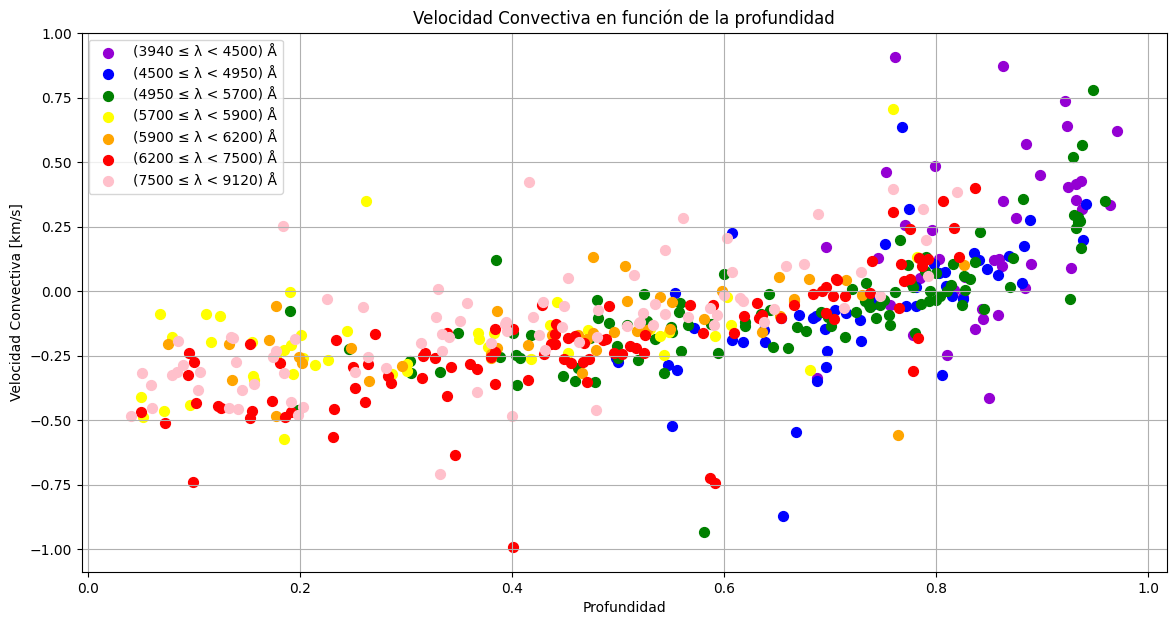

In [11]:
# Definir rangos de longitud de onda y colores
rangos = [(3940, 4500), (4500, 4950), (4950, 5700), (5700, 5900), (5900, 6200), (6200, 7500), (7500, 9120)]
colores = ['darkviolet', 'blue', 'green', 'yellow', 'orange','red', 'pink']
etiquetas = ['(3940 ≤ λ < 4500) Å', '(4500 ≤ λ < 4950) Å', '(4950 ≤ λ < 5700) Å', '(5700 ≤ λ < 5900) Å', '(5900 ≤ λ < 6200) Å', '(6200 ≤ λ < 7500) Å', '(7500 ≤ λ < 9120) Å']

# Crear lista de colores según el rango de λ_teo
colors = []
for lam in df_resultados['λ_obs (Å)']:
    for i, (low, high) in enumerate(rangos):
        if low <= lam < high:
            colors.append(colores[i])
            break

# Scatter plot por rango
plt.figure(figsize=(14, 7))
for color, etiqueta in zip(colores, etiquetas):
    mask = np.array(colors) == color
    plt.scatter(df_resultados['Profundidad'][mask], 
                df_resultados['Velocidad (km/s)'][mask], 
                color=color, label=etiqueta, s=50)

plt.xlabel("Profundidad")
plt.ylabel("Velocidad Convectiva [km/s]")
plt.title("Velocidad Convectiva en función de la profundidad")
plt.grid(True)
plt.legend()
plt.show()

#Hace falta revisar las lineas que tienen posibles mezclas para ver si las meto dentro del análisis y realizar la normalización de 3200 a 3950 A.